In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
import corner
import scienceplots
from scipy.optimize import fsolve
plt.style.use(['science','grid','bright'])
%matplotlib inline

In [2]:
G = const.G
pi = np.pi
msun = u.Msun
rsun = u.Rsun
kms = (u.km) / (u.s)
day = u.day

In [3]:
def f(q):
    return 0.49 * q**(2/3) / (0.6 * q**(2/3) + np.log(1 + q**(1/3)))

In [4]:
def solve_kepler_equation(e, M):
    """
    Solves Kepler's equation M - E - e*sin(E) = 0 for E.

    Parameters:
        M (float): Mean anomaly (radians).
        e (float): Orbital eccentricity.

    Returns:
        float: Eccentric anomaly (radians).
    """
    # Initial guess for E: a good choice is M itself
    E_guess = np.ones(len(M))*M
    
    # Define the function to solve
    def kepler(E, e, M):
        return E - e * np.sin(E) - M

    # Solve using fsolve
    E_solution = sp.optimize.newton(kepler, E_guess, args = (e, M))#fsolve(kepler, E_guess)
    return E_solution

In [5]:
def kick(vkick_min, vkick_max, N):
    """
    Generates kick magnitudes and directions.

    Parameters:
        vkick_min (float): Minimum kick magnitude.
        vkick_max (float): Maximum kick magnitude.
        N (int): Number of samples to generate.

    Returns:
        tuple: 
            - magnitudes (array): Kick magnitudes (size N).
            - directions (array): Array of polar and azimuthal angles (size N x 2).
    """
    # Generate magnitudes uniformly
    vkick_min = vkick_min.to('km/s').value
    vkick_max = vkick_max.to('km/s').value
    magnitudes = np.random.uniform(vkick_min, vkick_max, N) * kms
    
    # Generate isotropic directions
    phi = np.arccos(2 * np.random.uniform(0,1,N) - 1)  # Polar angle
    omega = 2 * np.pi * np.random.uniform(0,1,N)          # Azimuthal angle

    # Combine directions
    directions = np.vstack((phi, omega)).T
    
    return magnitudes, directions

def sample_orbital_period(P_min, P_max, N):
    """
    Generates a uniform distribution of orbital periods.

    Parameters:
        P_min (float): Minimum orbital period (days).
        P_max (float): Maximum orbital period (days).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of sampled orbital periods (size N).
    """
    P_min = P_min.to('day').value
    P_max = P_max.to('day').value
    return np.random.uniform(P_min, P_max, N) * day

def sample_mass_loss(delta_m_min, delta_m_max, N):
    """
    Generates a uniform distribution of mass loss values during the SN.

    Parameters:
        delta_m_min (float): Minimum mass loss (M_sun).
        delta_m_max (float): Maximum mass loss (M_sun).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of sampled mass loss values (size N).
    """
    delta_m_min = delta_m_min.to('Msun').value
    delta_m_max = delta_m_max.to('Msun').value
    return np.random.uniform(delta_m_min, delta_m_max, N) * msun

def calculate_progenitor_mass(delta_m, M_min):
    """
    Calculates the progenitor mass based on mass loss.

    Parameters:
        delta_m (np.ndarray): Array of mass loss values (M_sun).
        M_min (float): Minimum progenitor mass (M_sun), corresponding to zero mass loss.

    Returns:
        np.ndarray: Array of progenitor masses (size N).
    """
    return M_min + delta_m

def sample_eccentricities(N):
    """
    Generates a uniform distribution of eccentricities.

    Parameters:
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of sampled eccentricities (size N) between 0 and 1.
    """
    return np.random.uniform(0, 1, N)

def sample_mean_anomaly(N):
    """
    Generates a uniform distribution of mean anomalies.

    Parameters:
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of sampled mean anomalies (size N) between 0 and 2*pi radians.
    """
    return np.random.uniform(0, 2 * np.pi, N)


In [28]:
speed1, angles1 = kick(0*kms,100*kms, int(1e6))

In [29]:
phi1, omega1 = angles1[:,0], angles1[:,1]

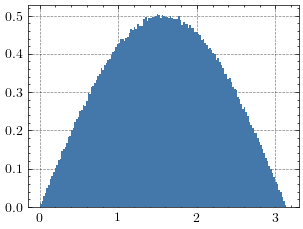

In [30]:
_ = plt.hist(phi1, density = True, bins = 'fd')

In [6]:
def compute_v_sys(vorb, sin_beta, cos_beta, vk, omega, phi, M1, M2, delta_M1):
    """
    Computes sin(β) based on the given parameters.

    Parameters:
        semi_major_axis (float): Orbital semi-major axis (m).
        eccentricity (float): Orbital eccentricity.
        radial_distance (float): Radial distance between the two stars (m).

    Returns:
        float: sin(β).
    """
    c1 = (M1 - delta_M1) / (M1 - delta_M1 + M2)
    x1 = vk * np.cos(omega) * np.cos(phi)
    y1 = vk * np.sin(omega) * np.cos(phi)
    z1 = vk * np.sin(phi)
    
    c2 = delta_M1 * M2 / ((M1 + M2) * (M1 - delta_M1 + M2))
    x2 = -vorb * sin_beta
    y2 = -vorb * cos_beta
    
    x = c1 * x1 - c2 * x2
    y = c1 * y1 - c2 * y2
    z = c1 * z1
    
    return (np.sqrt(x**2 + y**2 + z**2)).to('km/s')

def compute_orbital_velocity(semi_major_axis, radial_distance, total_mass):
    """
    Computes sin(β) based on the given parameters.

    Parameters:
        semi_major_axis (float): Orbital semi-major axis (m).
        eccentricity (float): Orbital eccentricity.
        radial_distance (float): Radial distance between the two stars (m).

    Returns:
        float: sin(β).
    """
    return (np.sqrt(G * total_mass * (2 / radial_distance - 1 / semi_major_axis))).to('km/s')

def compute_radial_distance(semi_major_axis, eccentricity, eccentric_anomaly):
    """
    Computes sin(β) based on the given parameters.

    Parameters:
        semi_major_axis (float): Orbital semi-major axis (m).
        eccentricity (float): Orbital eccentricity.
        radial_distance (float): Radial distance between the two stars (m).

    Returns:
        float: sin(β).
    """
    return (a * (1 - eccentricity * np.cos(eccentric_anomaly))).to('Rsun')

def compute_sin_beta(semi_major_axis, eccentricity, radial_distance):
    """
    Computes sin(β) based on the given parameters.

    Parameters:
        semi_major_axis (float): Orbital semi-major axis (m).
        eccentricity (float): Orbital eccentricity.
        radial_distance (float): Radial distance between the two stars (m).

    Returns:
        float: sin(β).
    """
    numerator = semi_major_axis**2 * (1 - eccentricity**2)
    denominator = radial_distance * (2 * semi_major_axis - radial_distance)
    return np.sqrt(numerator / denominator)

def compute_cos_beta(eccentricity, eccentric_anomaly):
    """
    Computes cos(β) based on the given parameters.

    Parameters:
        eccentricity (float): Orbital eccentricity.
        eccentric_anomaly (float): Eccentric anomaly (radians).

    Returns:
        float: cos(β).
    """
    numerator = -eccentricity * np.sin(eccentric_anomaly)
    denominator = np.sqrt(1 - eccentricity**2 * np.cos(eccentric_anomaly)**2)
    return numerator / denominator


def post_SN_relative_velocity_squared(kick_velocity, orbital_velocity, omega, phi, sin_beta, cos_beta):
    """
    Computes the post-supernova relative velocity of the stars.

    Parameters:
        kick_velocity (float): Kick velocity magnitude (m/s).
        orbital_velocity (float): Orbital velocity magnitude (m/s).
        omega (float): Angle between the kick velocity vector and the orbital plane (radians).
        phi (float): Angle between the kick velocity vector and the orbital velocity vector (radians).
        beta (float): Angle between the radial vector and orbital velocity vector (radians).

    Returns:
        float: Post-supernova relative velocity (m/s).
    """
    # Compute each term of the relative velocity equation
    term1 = orbital_velocity**2
    term2 = kick_velocity**2
    term3 = 2 * orbital_velocity * kick_velocity * (
        np.cos(omega) * np.cos(phi) * sin_beta 
        + np.sin(omega) * np.cos(phi) * cos_beta)

    # Sum the terms and take the square root for the relative velocity magnitude
    relative_velocity = term1 + term2 - term3
    return relative_velocity

def semi_major_axis_from_v_r(v, r , total_mass):
    """
    Computes the post-supernova relative velocity of the stars.

    Parameters:
        kick_velocity (float): Kick velocity magnitude (m/s).
        orbital_velocity (float): Orbital velocity magnitude (m/s).
        omega (float): Angle between the kick velocity vector and the orbital plane (radians).
        phi (float): Angle between the kick velocity vector and the orbital velocity vector (radians).
        beta (float): Angle between the radial vector and orbital velocity vector (radians).

    Returns:
        float: Post-supernova relative velocity (m/s).
    """
    
    a_inverse = 2/r - v**2 / (G * total_mass)
    return (a_inverse**(-1)).to('Rsun')

def new_eccentricity(total_mass, a , r, vk, phi, omega, vorb, sin_beta):
    """
    Computes the post-supernova relative velocity of the stars.

    Parameters:
        kick_velocity (float): Kick velocity magnitude (m/s).
        orbital_velocity (float): Orbital velocity magnitude (m/s).
        omega (float): Angle between the kick velocity vector and the orbital plane (radians).
        phi (float): Angle between the kick velocity vector and the orbital velocity vector (radians).
        beta (float): Angle between the radial vector and orbital velocity vector (radians).

    Returns:
        float: Post-supernova relative velocity (m/s).
    """
    
    r_cross_vn_squared = r**2 * ((vk * np.sin(phi))**2 + (vk * np.cos(omega) * np.cos(phi) - vorb * sin_beta)**2)
    new_e = np.sqrt(1 - r_cross_vn_squared/(G * total_mass * a))
    return new_e

def v_orb(primary_mass, secondary_mass, semi_major_axis):
    """
    Computes the orbital velocity.

    Parameters:
        primary_mass (float): Mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        semi_major_axis (float): Orbital semi-major axis (m).

    Returns:
        float: Orbital velocity (m/s).
    """
    return (np.sqrt(G * (primary_mass + secondary_mass) / semi_major_axis)).to('km/s')

def P_orb(primary_mass, secondary_mass, semi_major_axis):
    """
    Computes the orbital period.

    Parameters:
        primary_mass (float): Mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        semi_major_axis (float): Orbital semi-major axis (m).

    Returns:
        float: Orbital period (days).
    """
    return (2 * pi * np.sqrt(semi_major_axis**3 / (G * (primary_mass + secondary_mass)))).to('day')

def pre_SN_a(M1, M2, P):
    """
    Computes the orbital period.

    Parameters:
        primary_mass (float): Mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        semi_major_axis (float): Orbital semi-major axis (m).

    Returns:
        float: Orbital period (days).
    """
    return (((P / (2*pi))**2 * G * (M1 + M2))**(1/3)).to('Rsun')

def m_tilde(pre_sn_primary_mass, post_sn_primary_mass, secondary_mass):
    """
    Computes the ratio of pre- to post-SN total masses.

    Parameters:
        pre_sn_primary_mass (float): Pre-SN mass of the primary star (kg).
        post_sn_primary_mass (float): Post-SN mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).

    Returns:
        float: Ratio of pre- to post-SN total masses.
    """
    return (pre_sn_primary_mass + secondary_mass) / (post_sn_primary_mass + secondary_mass)

def v_tilde(kick_velocity, orbital_velocity):
    """
    Computes the scaled kick velocity.

    Parameters:
        kick_velocity (float): Kick velocity (m/s).
        orbital_velocity (float): Orbital velocity (m/s).

    Returns:
        float: Scaled kick velocity.
    """
    return kick_velocity / orbital_velocity

def post_SN_eccentricity(mass_ratio, scaled_kick_velocity, kick_angle_phi, kick_angle_omega):
    """
    Computes the post-SN eccentricity.

    Parameters:
        mass_ratio (float): Ratio of pre- to post-SN total masses.
        scaled_kick_velocity (float): Scaled kick velocity.
        kick_angle_phi (float): Angle between orbital and kick velocity vectors (radians).
        kick_angle_theta (float): Angle between orbital plane and kick velocity vector (radians).

    Returns:
        float: Post-SN eccentricity.
    """
    term1 = 2 - mass_ratio * (1 + 2 * scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi) + scaled_kick_velocity**2)
    term2 = (1 + scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi))**2 + (scaled_kick_velocity * np.sin(kick_angle_phi))**2
    return np.sqrt(1 - mass_ratio * term1 * term2)

def post_SN_semi_major_axis(pre_sn_semi_major_axis, mass_ratio, scaled_kick_velocity, kick_angle_phi, kick_angle_omega):
    """
    Computes the post-SN semi-major axis.

    Parameters:
        pre_sn_semi_major_axis (float): Pre-SN semi-major axis (m).
        mass_ratio (float): Ratio of pre- to post-SN total masses.
        scaled_kick_velocity (float): Scaled kick velocity.
        kick_angle_phi (float): Angle between orbital and kick velocity vectors (radians).
        kick_angle_theta (float): Angle between orbital plane and kick velocity vector (radians).

    Returns:
        float: Post-SN semi-major axis (m).
    """
    term1 = 2 - mass_ratio * (1 + 2 * scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi) + scaled_kick_velocity**2)
    return pre_sn_semi_major_axis / term1

def post_SN_system_velocity(pre_sn_primary_mass, post_sn_primary_mass, secondary_mass, orbital_velocity, scaled_kick_velocity, kick_angle_phi, kick_angle_omega):
    """
    Computes the post-SN systemic velocity of the binary system.

    Parameters:
        pre_sn_primary_mass (float): Pre-SN mass of the primary star (kg).
        post_sn_primary_mass (float): Post-SN mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        orbital_velocity (float): Initial orbital velocity (m/s).
        scaled_kick_velocity (float): Scaled kick velocity.
        kick_angle_phi (float): Angle between orbital and kick velocity vectors (radians).
        kick_angle_theta (float): Angle between orbital plane and kick velocity vector (radians).

    Returns:
        float: Post-SN systemic velocity (m/s).
    """
    reduced_mass = (pre_sn_primary_mass * secondary_mass) / (pre_sn_primary_mass + secondary_mass)  # Reduced mass
    delta_primary_mass = pre_sn_primary_mass - post_sn_primary_mass  # Mass lost during SN
    
    term1 = (reduced_mass * delta_primary_mass / pre_sn_primary_mass)**2
    term2 = -2 * (reduced_mass * delta_primary_mass * post_sn_primary_mass / pre_sn_primary_mass) * scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi)
    term3 = (post_sn_primary_mass * scaled_kick_velocity)**2
    system_velocity = (orbital_velocity / (post_sn_primary_mass + secondary_mass)) * np.sqrt(term1 + term2 + term3)
    
    return system_velocity


**Verifying Circular orbits in El-Badry http://arxiv.org/abs/2404.13047**

In [7]:
np.random.seed(1234)
N = int(1e7)
M2 = 0.78 * msun

vkick_min, vkick_max = 0 * kms, 100 * kms
speed, angles = kick(vkick_min, vkick_max, N)
phi = angles[:,0]
phi = pi - phi
omega = angles[:,1]

P_min, P_max = 0 * day, 8500 * day
period = sample_orbital_period(P_min, P_max, N)

delta_m_min, delta_m_max = 0 * msun, 67 * msun
delta_m = sample_mass_loss(delta_m_min, delta_m_max, N)

M1_prime = 33 * msun
M1 = calculate_progenitor_mass(delta_m, M1_prime)

a = pre_SN_a(M1, M2, period)
vorb = v_orb(M1, M2, a)

mtilde = m_tilde(M1, M1_prime, M2)
vtilde = v_tilde(speed, vorb)
e = post_SN_eccentricity(mtilde, vtilde, phi, omega)
vsys = post_SN_system_velocity(M1, M1_prime, M2, vorb, vtilde, phi, omega)
final_a = post_SN_semi_major_axis(a, mtilde, vtilde, phi, omega)
final_period = P_orb(M1_prime, M2, final_a)

/home/u16/neevshah/micromamba/envs/XRB/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [8]:
# Create the Astropy table with units preserved
table = Table(
    {
        "m1": M1,           # M1 with units (e.g., Msun)
        "a": a,             # Semi-major axis with units (e.g., AU)
        "period": period,   # Orbital period with units (e.g., day)
        "v_orb": vorb,      # Orbital velocity with units (e.g., km/s)
        "kick": speed,      # Kick speed with units (e.g., km/s)
        "phi": phi,     # Kick angle theta (radians)
        "omega": omega,         # Kick angle phi (radians)
        "e": e,             # Post-SN eccentricity (dimensionless)
        "v_sys": vsys,      # Systemic velocity with units (e.g., km/s)
        "final_a": final_a,
        "final_period": final_period
    }
)

In [ ]:
table

(0.0, 5.0)

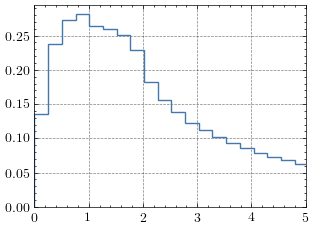

In [9]:
_ = plt.hist(table['e'], bins = 100, density = True, histtype = 'step')
plt.xlim(0,5)

In [10]:
e_cond = (table['e'] < 0.78) & (table['e'] > 0.68)
p_cond = (table['final_period'] < 4500 * day) & (table['final_period'] > 4000 * day)

table_subset = table[e_cond & p_cond]
bound_cond = table_subset['v_sys'] < 10 * kms

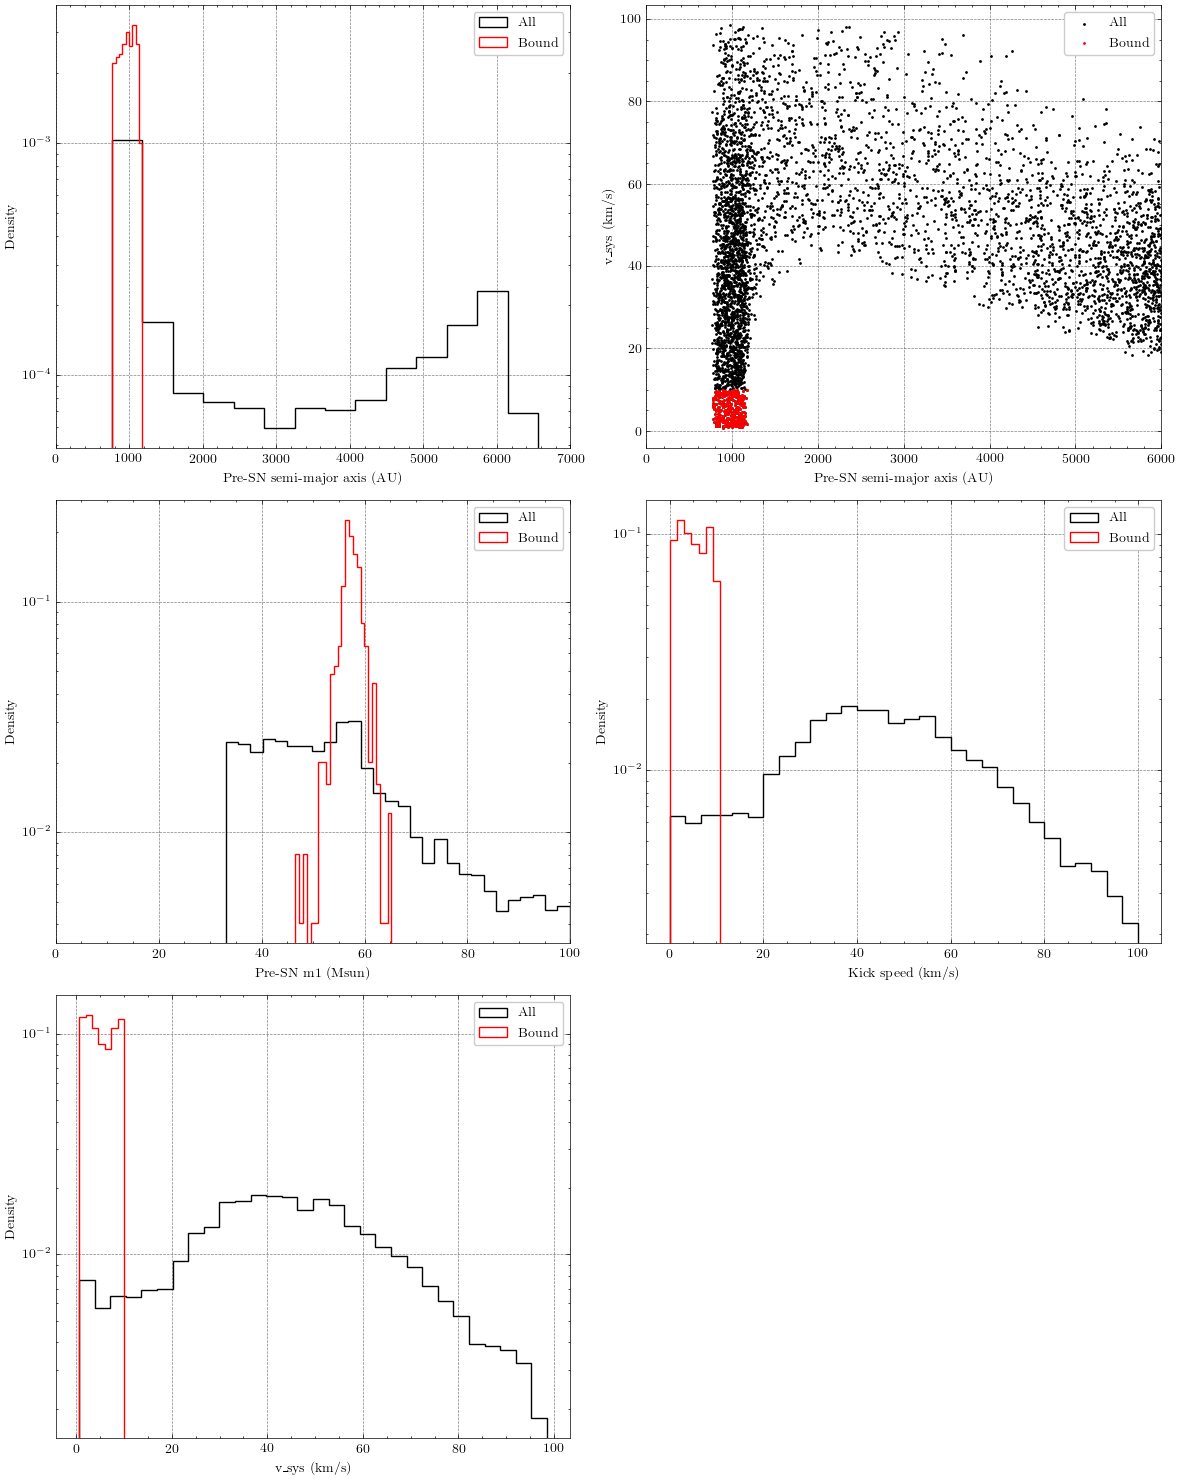

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.set_tight_layout(True)

# Histogram for Pre-SN semi-major axis
axs[0, 0].hist(table_subset['a'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[0, 0].hist(table_subset[bound_cond]['a'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('Pre-SN semi-major axis (AU)')
axs[0, 0].set_ylabel('Density')
axs[0,0].set_xlim(0,7000)
axs[0, 0].legend()

# Scatter plot for Pre-SN semi-major axis vs v_sys
axs[0, 1].scatter(table_subset['a'], table_subset['v_sys'], s=1, color='black', label="All")
axs[0, 1].scatter(table_subset[bound_cond]['a'], table_subset[bound_cond]['v_sys'], s=1, color='red', label="Bound")
axs[0, 1].set_xlabel('Pre-SN semi-major axis (AU)')
axs[0, 1].set_ylabel('v_sys (km/s)')
axs[0,1].set_xlim(0,6000)
axs[0, 1].legend()

# Histogram for m1
axs[1, 0].hist(table_subset['m1'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[1, 0].hist(table_subset[bound_cond]['m1'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Pre-SN m1 (Msun)')
axs[1, 0].set_ylabel('Density')
axs[1,0].set_xlim(0,100)
axs[1, 0].legend()

# Histogram for kick
axs[1, 1].hist(table_subset['kick'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[1, 1].hist(table_subset[bound_cond]['kick'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Kick speed (km/s)')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

# Histogram for v_sys
axs[2, 0].hist(table_subset['v_sys'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[2, 0].hist(table_subset[bound_cond]['v_sys'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel('v_sys (km/s)')
axs[2, 0].set_ylabel('Density')
axs[2, 0].legend()

# Remove the empty subplot
fig.delaxes(axs[2, 1])

# Display the plots
plt.show()

**Verifying Eccentric orbits in El-Badry http://arxiv.org/abs/2404.13047**

In [ ]:
np.random.seed(1234)
N = int(1e7)
M2 = 0.78 * msun

vkick_min, vkick_max = 0 * kms, 100 * kms
speed, angles = kick(vkick_min, vkick_max, N)
phi = angles[:,0]
omega = angles[:,1]

P_min, P_max = 0 * day, 8500 * day
period = sample_orbital_period(P_min, P_max, N)

delta_m_min, delta_m_max = 0 * msun, 67 * msun
delta_m = sample_mass_loss(delta_m_min, delta_m_max, N)

initial_e = sample_eccentricities(N)
M = sample_mean_anomaly(N)
E = solve_kepler_equation(initial_e, M)

M1_prime = 33 * msun
M1 = calculate_progenitor_mass(delta_m, M1_prime)

a = pre_SN_a(M1, M2, period)

r = compute_radial_distance(a, initial_e, E)
sin_beta = compute_sin_beta(a, initial_e, r)
cos_beta = compute_cos_beta(initial_e, E)
vorb = compute_orbital_velocity(a, r, M1+M2)
vn_squared = post_SN_relative_velocity_squared(speed, vorb, omega, phi, sin_beta, cos_beta)
vn = np.sqrt(vn_squared)
final_a = semi_major_axis_from_v_r(vn, r , M1_prime+M2)
e = new_eccentricity(M1_prime+M2, final_a, r, speed, phi, omega, vorb, sin_beta)
vsys = compute_v_sys(vorb, sin_beta, cos_beta, speed, omega, phi, M1, M2, M1-M1_prime)
final_period = P_orb(M1_prime, M2, final_a)

In [ ]:
# Create the Astropy table with units preserved
table = Table(
    {
        "m1": M1,           # M1 with units (e.g., Msun)
        "a": a,             # Semi-major axis with units (e.g., AU)
        "period": period,   # Orbital period with units (e.g., day)
        "v_orb": vorb,      # Orbital velocity with units (e.g., km/s)
        "kick": speed,      # Kick speed with units (e.g., km/s)
        "omega": omega,     # Kick angle theta (radians)
        "phi": phi,         # Kick angle phi (radians)
        "e": e,             # Post-SN eccentricity (dimensionless)
        "v_sys": vsys,      # Systemic velocity with units (e.g., km/s)
        "final_a": final_a,
        "final_period": final_period,
        "d_peri": a * (1 - initial_e),
        "e_init": initial_e
    }
)

e_cond = (table['e'] < 0.78) & (table['e'] > 0.68)
p_cond = (table['final_period'] < 4500 * day) & (table['final_period'] > 4000 * day)

table_subset = table[e_cond & p_cond]
bound_cond = table_subset['v_sys'] < 10 * kms

In [ ]:
table

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.set_tight_layout(True)

# Histogram for Pre-SN semi-major axis
axs[0, 0].hist(table_subset['d_peri'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[0, 0].hist(table_subset[bound_cond]['d_peri'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('Pre-SN d_peri (Rsun)')
axs[0, 0].set_ylabel('Density')
axs[0,0].set_xlim(0,7000)
axs[0, 0].legend()

# Scatter plot for Pre-SN semi-major axis vs v_sys
axs[0, 1].scatter(table_subset['d_peri'], table_subset['v_sys'], s=1, color='black', label="All")
axs[0, 1].scatter(table_subset[bound_cond]['d_peri'], table_subset[bound_cond]['v_sys'], s=1, color='red', label="Bound")
axs[0, 1].set_xlabel('Pre-SN d_peri (Rsun)')
axs[0, 1].set_ylabel('v_sys (km/s)')
axs[0,1].set_xlim(0,6000)
axs[0, 1].legend()

# Histogram for m1
axs[1, 0].hist(table_subset['m1'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[1, 0].hist(table_subset[bound_cond]['m1'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Pre-SN m1 (Msun)')
axs[1, 0].set_ylabel('Density')
axs[1,0].set_xlim(0,100)
axs[1, 0].legend()

# Histogram for kick
axs[1, 1].hist(table_subset['kick'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[1, 1].hist(table_subset[bound_cond]['kick'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Kick speed (km/s)')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

# Histogram for v_sys
axs[2, 0].hist(table_subset['v_sys'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[2, 0].hist(table_subset[bound_cond]['v_sys'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel('v_sys (km/s)')
axs[2, 0].set_ylabel('Density')
axs[2, 0].legend()

# Histogram for v_sys
axs[2, 1].hist(table_subset['e_init'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[2, 1].hist(table_subset[bound_cond]['e_init'], bins='fd', density=True, color='red', histtype='step', label="Bound")
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel('e_init')
axs[2, 1].set_ylabel('Density')
axs[2, 1].legend()

# Display the plots
plt.show()

**Runaway XRB**

In [7]:
np.random.seed(1234)
N = int(1e7)
M2 = 58 * msun

vkick_min, vkick_max = 0 * kms, 2000 * kms
speed, angles = kick(vkick_min, vkick_max, N)
phi = angles[:,0]
phi = pi/2 - phi
omega = angles[:,1]

P_min, P_max = 0 * day, 30 * day
period = sample_orbital_period(P_min, P_max, N)

delta_m_min, delta_m_max = 0 * msun, 30 * msun
delta_m = sample_mass_loss(delta_m_min, delta_m_max, N)

M1_prime = 2.5 * msun
M1 = calculate_progenitor_mass(delta_m, M1_prime)

a = pre_SN_a(M1, M2, period)
vorb = v_orb(M1, M2, a)

mtilde = m_tilde(M1, M1_prime, M2)
vtilde = v_tilde(speed, vorb)
e = post_SN_eccentricity(mtilde, vtilde, phi, omega)
vsys = post_SN_system_velocity(M1, M1_prime, M2, vorb, vtilde, phi, omega)
final_a = post_SN_semi_major_axis(a, mtilde, vtilde, phi, omega)
final_period = P_orb(M1_prime, M2, final_a)

/home/u16/neevshah/micromamba/envs/XRB/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [10]:
q = M2 / M1
pre_rl_2 = a * f(q)
post_rl_2 = final_a * (1 - e) * f(M2 / M1_prime)

# Create the Astropy table with units preserved
table = Table(
    {
        "m1": M1,           # M1 with units (e.g., Msun)
        "a": a,             # Semi-major axis with units (e.g., AU)
        "period": period,   # Orbital period with units (e.g., day)
        "v_orb": vorb,      # Orbital velocity with units (e.g., km/s)
        "kick": speed,      # Kick speed with units (e.g., km/s)
        "phi": phi,     # Kick angle theta (radians)
        "omega": omega,         # Kick angle phi (radians)
        "e": e,             # Post-SN eccentricity (dimensionless)
        "v_sys": vsys,      # Systemic velocity with units (e.g., km/s)
        "final_a": final_a,
        "final_period": final_period,
        "pre_rl_2": pre_rl_2,
        "post_rl_2": post_rl_2
    }
)

In [51]:
e_cond = (table['e'] > 0.18) & (table['e'] < 1)
p_cond = (table['final_period'] > 1 * day) & (table['final_period'] < 3.5 * day)

table_subset = table[e_cond & p_cond]
eject_cond = (table_subset['v_sys'] > 50 * kms) & (table_subset['v_sys'] < 75 * kms)

pre_roche_lobe_cond = (table_subset['pre_rl_2'] > 10 * rsun)
post_roche_lobe_cond = (table_subset['post_rl_2'] > 10 * rsun)

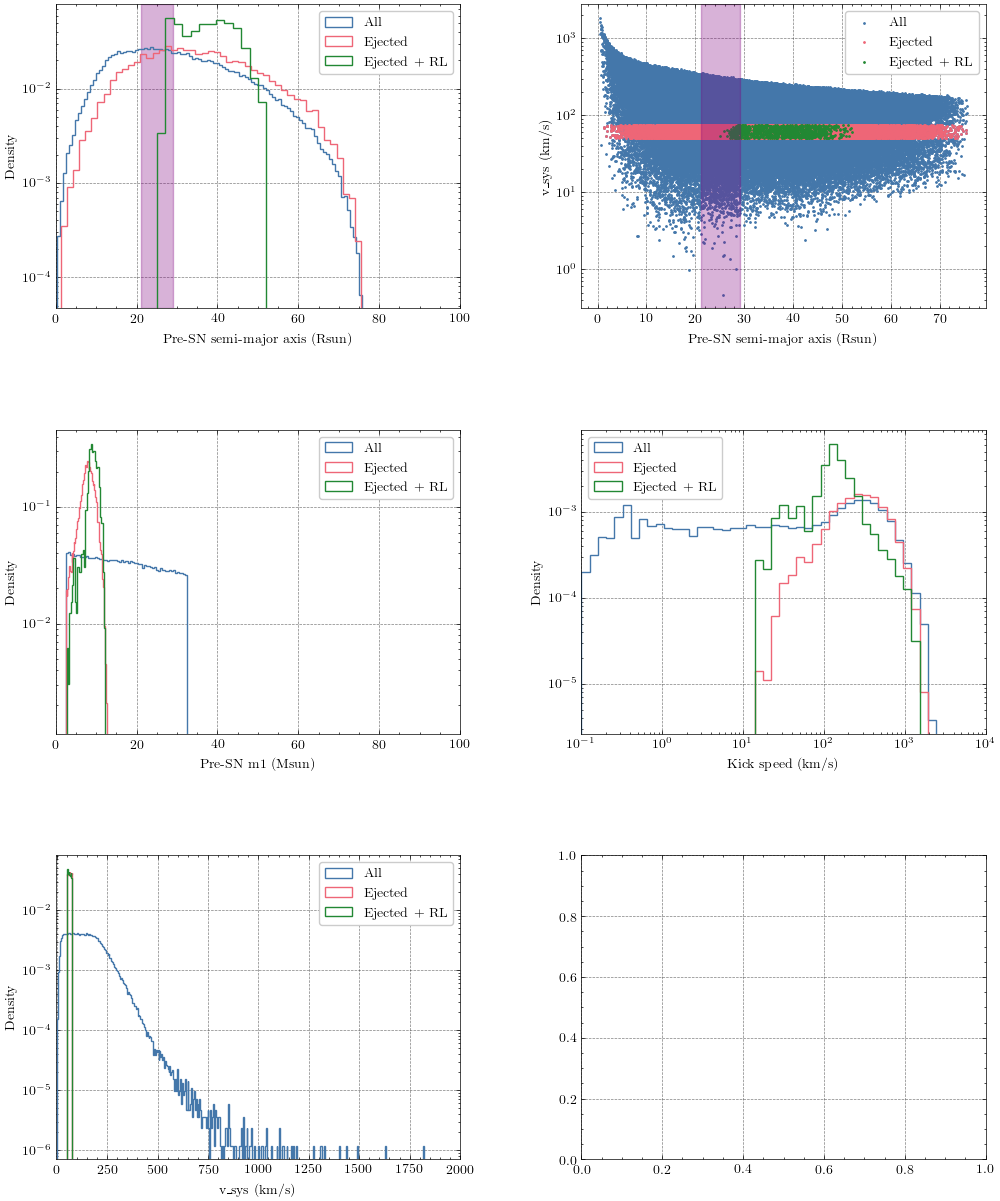

In [47]:
# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Histogram for Pre-SN semi-major axis
axs[0, 0].hist(table_subset['a'], bins='fd', density=True, histtype='step', label="All")
axs[0, 0].hist(table_subset[eject_cond]['a'], bins='fd', density=True, histtype='step', label="Ejected")
axs[0, 0].hist(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['a'], bins='fd', density=True, histtype='step', label="Ejected + RL")
axs[0,0].axvspan(25.1-4, 25.1+4, color = 'purple', alpha = 0.3)
axs[0, 0].set_xlim(0, 100)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('Pre-SN semi-major axis (Rsun)')
axs[0, 0].set_ylabel('Density')
axs[0, 0].legend()

# Scatter plot for Pre-SN semi-major axis vs v_sys
axs[0, 1].scatter(table_subset['a'], table_subset['v_sys'], s=1, label="All")
axs[0, 1].scatter(table_subset[eject_cond]['a'], table_subset[eject_cond]['v_sys'], s=1, label="Ejected")
axs[0, 1].scatter(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['a'], table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['v_sys'], s=1, label="Ejected + RL")
axs[0,1].axvspan(25.1-4, 25.1+4, color = 'purple', alpha = 0.3)
axs[0, 1].set_xlabel('Pre-SN semi-major axis (Rsun)')
axs[0, 1].set_ylabel('v_sys (km/s)')
axs[0, 1].set_yscale('log')
axs[0, 1].legend()

# Histogram for m1
axs[1, 0].hist(table_subset['m1'], bins='fd', density=True, histtype='step', label="All")
axs[1, 0].hist(table_subset[eject_cond]['m1'], bins='fd', density=True, histtype='step', label="Ejected")
axs[1, 0].hist(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['m1'], bins='fd', density=True, histtype='step', label="Ejected + RL")
axs[1, 0].set_xlim(0, 100)
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Pre-SN m1 (Msun)')
axs[1, 0].set_ylabel('Density')
axs[1, 0].legend()

# Histogram for kick
axs[1, 1].hist(table_subset['kick'], bins=np.logspace(-1,4,50), density=True, histtype='step', label="All")
axs[1, 1].hist(table_subset[eject_cond]['kick'], bins=np.logspace(-1,4,50), density=True, histtype='step', label="Ejected")
axs[1, 1].hist(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['kick'], bins=np.logspace(-1,4,50), density=True, histtype='step', label="Ejected + RL")
axs[1, 1].set_xlim(0.1, 1e4)
axs[1, 1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1, 1].set_xlabel('Kick speed (km/s)')
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

# Histogram for v_sys
axs[2, 0].hist(table_subset['v_sys'], bins='fd', density=True, histtype='step', label="All")
axs[2, 0].hist(table_subset[eject_cond]['v_sys'], bins='fd', density=True, histtype='step', label="Ejected")
axs[2, 0].hist(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['v_sys'], bins='fd', density=True, histtype='step', label="Ejected + RL")
axs[2, 0].set_xlim(-5, 2e3)
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel('v_sys (km/s)')
axs[2, 0].set_ylabel('Density')
axs[2, 0].legend()

# # Histogram for Pre-SN semi-major axis
# axs[2, 1].hist(table_subset['rl_2'], bins='fd', density=True, histtype='step', label="All")
# axs[2, 1].hist(table_subset[eject_cond]['rl_2'], bins='fd', density=True, histtype='step', label="Ejected")
# axs[2, 1].hist(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['rl_2'], bins='fd', density=True, histtype='step', label="Ejected + RL")
# axs[2, 1].axvspan(25.1-4, 25.1+4, color = 'purple', alpha = 0.3)
# axs[2, 1].set_xlim(0, 100)
# axs[2, 1].set_yscale('log')
# axs[2, 1].set_xlabel('Pre-SN RL_2 (Rsun)')
# axs[2, 1].set_ylabel('Density')
# axs[2, 1].legend()

# Display the plots
plt.show()

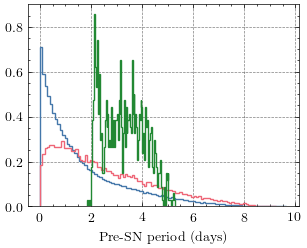

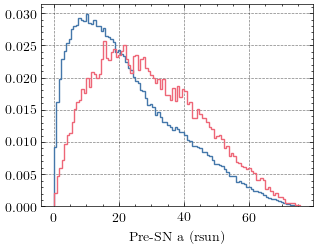

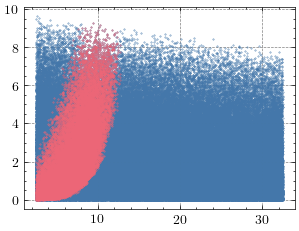

(0.1, 100.0)

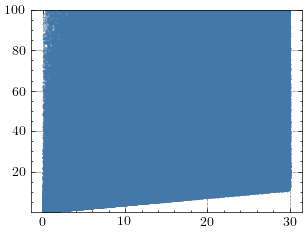

In [25]:
_ = plt.hist(table_subset['period'], bins = 100, density = True, histtype='step', label = 'All')
_ = plt.hist(table_subset[eject_cond]['period'], bins = 100, density = True, histtype='step', label = 'Eject')
_ = plt.hist(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['period'], bins = 100, density = True, histtype='step', label = 'Eject + RL')
plt.xlabel('Pre-SN period (days)')
plt.show()

_ = plt.hist(table_subset['a'], bins = 100, density = True, histtype='step', label = 'All')
_ = plt.hist(table_subset[eject_cond]['a'], bins = 100, density = True, histtype='step', label = 'Eject')
plt.xlabel('Pre-SN a (rsun)')
plt.show()

plt.scatter(table_subset['m1'],table_subset['period'], s = 0.1)
plt.scatter(table_subset[eject_cond]['m1'],table_subset[eject_cond]['period'], s = 0.1)
#_ = plt.hist(table_subset[eject_cond & roche_lobe_cond]['period'], bins = 100, density = True, histtype='step')
plt.show()

plt.scatter(table[table['e']<1000]['period'],table[table['e']<1000]['final_period'], s = 0.1)
#plt.yscale('log')
plt.ylim(1e-1,1e2)
#plt.scatter(table_subset[eject_cond]['period'],table_subset[eject_cond]['final_period'], s = 0.1)

(0.0, 100.0)

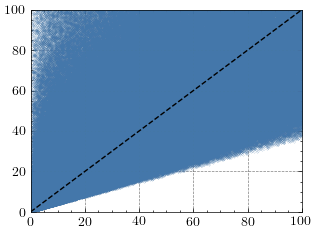

In [47]:
#plt.scatter(table_subset['period'],table_subset['final_period'], s = 0.1)
plt.plot(np.linspace(0,100,100), np.linspace(0,100,100), 'k--')
plt.scatter(table[table['e']<1]['a']**(3/2) / ((table[table['e']<1]['m1'] + 58)**(0.5)), table[table['e']<1]['final_a']**(3/2) / ((2.5 + 58)**(0.5)), s = 0.01)
plt.xlim(0,100)
plt.ylim(0,100)

(0.0, 30.0)

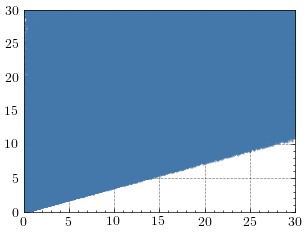

In [48]:
plt.scatter(table['period'],table['final_period'], s = 0.1)
plt.xlim(0,30)
plt.ylim(0,30)

In [21]:
table_subset[eject_cond][table_subset[eject_cond]['period'] > 3.5]

m1,a,period,v_orb,kick,phi,omega,e,v_sys,final_a,final_period,rl_2
solMass,solRad,d,km / s,km / s,,,,km / s,solRad,d,solRad
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7.776082316112811,42.517272782928345,3.9596555801184516,543.2454744273027,456.0825674803315,0.6370127384685806,3.837778477840886,0.5774071881356847,55.42139961914716,33.4128347062974,2.8763094619844183,23.574682227511914
8.04083058472651,41.92770441790381,3.869801406177497,548.1514107411493,640.0073458377316,3.020574455916118,6.106301195691766,0.9576550496664679,70.15815513637936,21.937638162730106,1.5302078658511173,23.131818988226446
6.2102788106547315,40.26797990211317,3.6938631427183486,551.5274996015946,569.066839540272,0.6970212363140372,3.1127921690842655,0.48823287477724137,50.869209890647454,27.072857057367237,2.0978129495056193,23.062828630147486
10.017225051740652,43.90208089811776,4.085653366212895,543.640392495149,507.1306017436419,0.6079103567287333,2.57603607565647,0.6156265093841272,73.68830356558412,32.49452818214216,2.758550759480506,23.412203236167674
8.537347657097785,41.35639649157593,3.7768053880800077,553.9954687783422,289.18133818301794,2.453642518929628,0.8081649256470682,0.39867673619185445,55.49562455506446,34.08545533178983,2.9635978868825097,22.61074938773586
7.435276901139726,44.70219073825927,4.279869753180675,528.4286841656576,452.9828711848061,0.4129764715865257,3.4947511521675096,0.8070964155539037,55.132011483691976,26.03135955300471,1.9779299325512585,24.95084835234341
10.60757871765208,42.59779631229964,3.888104836601931,554.290321397319,218.16530292038317,2.259424722238271,6.105168339714224,0.25415202918759017,68.79450683470881,34.11569815351847,2.967543005391277,22.509150735604596
7.5740515385688765,54.5442226764247,5.762360707514192,478.8907469170943,434.8086392239954,2.794783393334507,6.118217361529452,0.8714097586848187,52.62227070367138,29.50723091813117,2.387032376979683,30.361474270958244


Text(0.5, 0, 'Pre SN period')

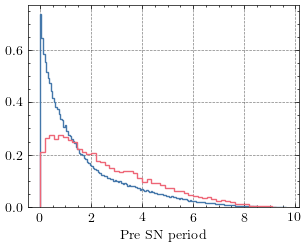

In [49]:
_ = plt.hist(table_subset['period'], bins = 'fd', histtype = 'step', density = True)
_ = plt.hist(table_subset[eject_cond]['period'], bins = 'fd', histtype = 'step', density = True)
plt.xlabel('Pre SN period')

(1.0, 1000.0)

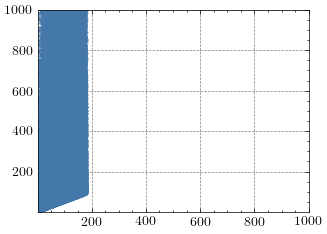

In [50]:
# _ = plt.scatter(np.sqrt(table_subset['a']**3/(table_subset['m1']+M2)), np.sqrt(table_subset['final_a']**3/(M1_prime+M2)), s = 0.1)
# plt.show()

plt.scatter(table[table['e']<1]['a'],table[table['e']<1]['final_a'], s = 0.1)
#plt.yscale('log')
plt.ylim(1e0,1e3)
plt.xlim(1e0,1e3)

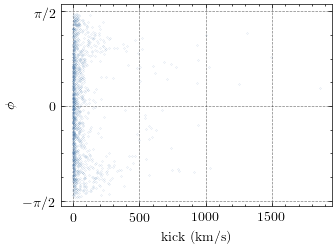

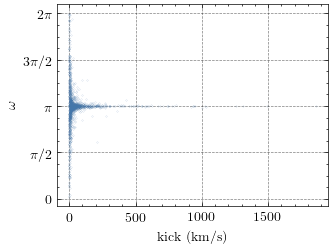

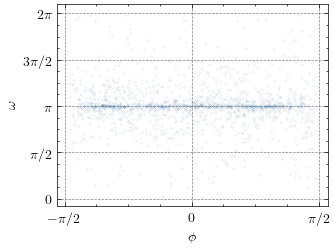

In [43]:
#plt.scatter(table_subset['kick'], table_subset['phi'], s = 0.1)
plt.scatter(table[table['e']<0.01]['kick'], table[table['e']<0.01]['phi'], s = 0.005)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\phi$')
plt.yticks([-pi/2,0,pi/2],[r'$-\pi/2$',r'$0$',r'$\pi/2$'])
plt.show()

#plt.scatter(table_subset['kick'], table_subset['omega'], s = 0.1)
plt.scatter(table[table['e']<0.01]['kick'], table[table['e']<0.01]['omega'], s = 0.005)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\omega$')
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

plt.scatter(table[table['e']<0.01]['phi'], table[table['e']<0.01]['omega'], s = 0.005)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\omega$')
plt.xticks([-pi/2,0,pi/2],[r'$-\pi/2$', r'$0$',r'$\pi/2$'])
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

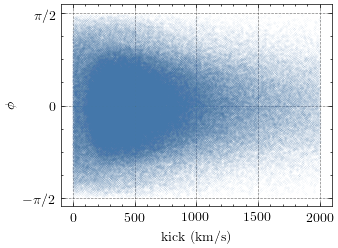

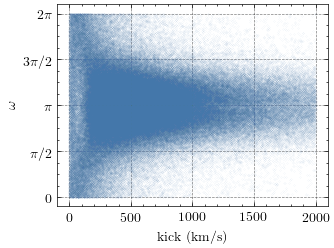

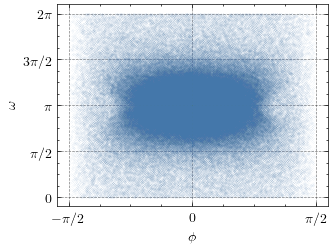

In [57]:
#plt.scatter(table_subset['kick'], table_subset['phi'], s = 0.1)
plt.scatter(table_subset['kick'], table_subset['phi'], s = 0.0005)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\phi$')
plt.yticks([-pi/2,0,pi/2],[r'$-\pi/2$',r'$0$',r'$\pi/2$'])
plt.show()

#plt.scatter(table_subset['kick'], table_subset['omega'], s = 0.1)
plt.scatter(table_subset['kick'], table_subset['omega'], s = 0.0005)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\omega$')
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

plt.scatter(table_subset['phi'], table_subset['omega'], s = 0.0005)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\omega$')
plt.xticks([-pi/2,0,pi/2],[r'$-\pi/2$',r'$0$',r'$\pi/2$'])
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

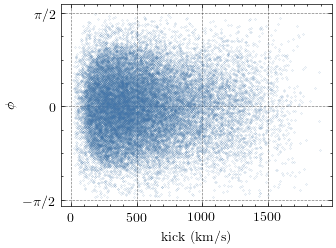

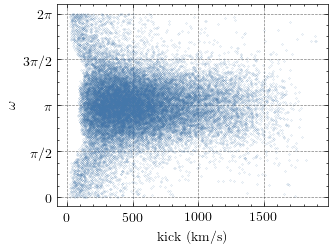

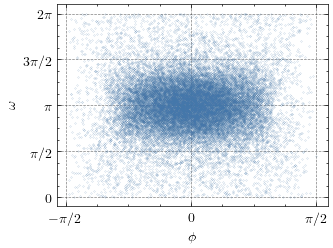

In [58]:
#plt.scatter(table_subset['kick'], table_subset['phi'], s = 0.1)
plt.scatter(table_subset[eject_cond]['kick'], table_subset[eject_cond]['phi'], s = 0.01)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\phi$')
plt.yticks([-pi/2,0,pi/2],[r'$-\pi/2$',r'$0$',r'$\pi/2$'])
plt.show()

#plt.scatter(table_subset['kick'], table_subset['omega'], s = 0.1)
plt.scatter(table_subset[eject_cond]['kick'], table_subset[eject_cond]['omega'], s = 0.01)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\omega$')
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

plt.scatter(table_subset[eject_cond]['phi'], table_subset[eject_cond]['omega'], s = 0.01)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\omega$')
plt.xticks([-pi/2,0,pi/2],[r'$-\pi/2$',r'$0$',r'$\pi/2$'])
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

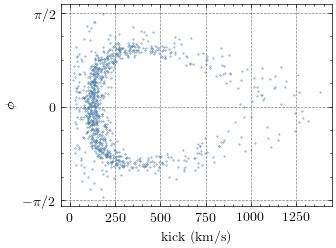

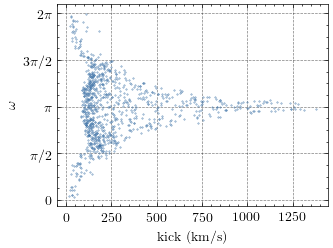

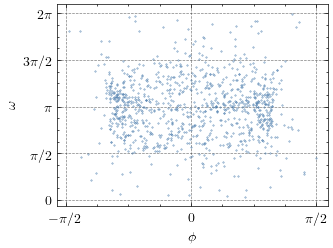

In [27]:
#plt.scatter(table_subset['kick'], table_subset['phi'], s = 0.1)
plt.scatter(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['kick'], table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['phi'], s = 0.1)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\phi$')
plt.yticks([-pi/2,0,pi/2],[r'$-\pi/2$',r'$0$',r'$\pi/2$'])
plt.show()

#plt.scatter(table_subset['kick'], table_subset['omega'], s = 0.1)
plt.scatter(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['kick'], table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['omega'], s = 0.1)
plt.xlabel('kick (km/s)')
plt.ylabel(r'$\omega$')
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

plt.scatter(table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['phi'], table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['omega'], s = 0.1)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\omega$')
plt.xticks([-pi/2,0,pi/2],[r'$-\pi/2$',r'$0$',r'$\pi/2$'])
plt.yticks([0,pi/2,pi,3*pi/2,2*pi],[r'$0$',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

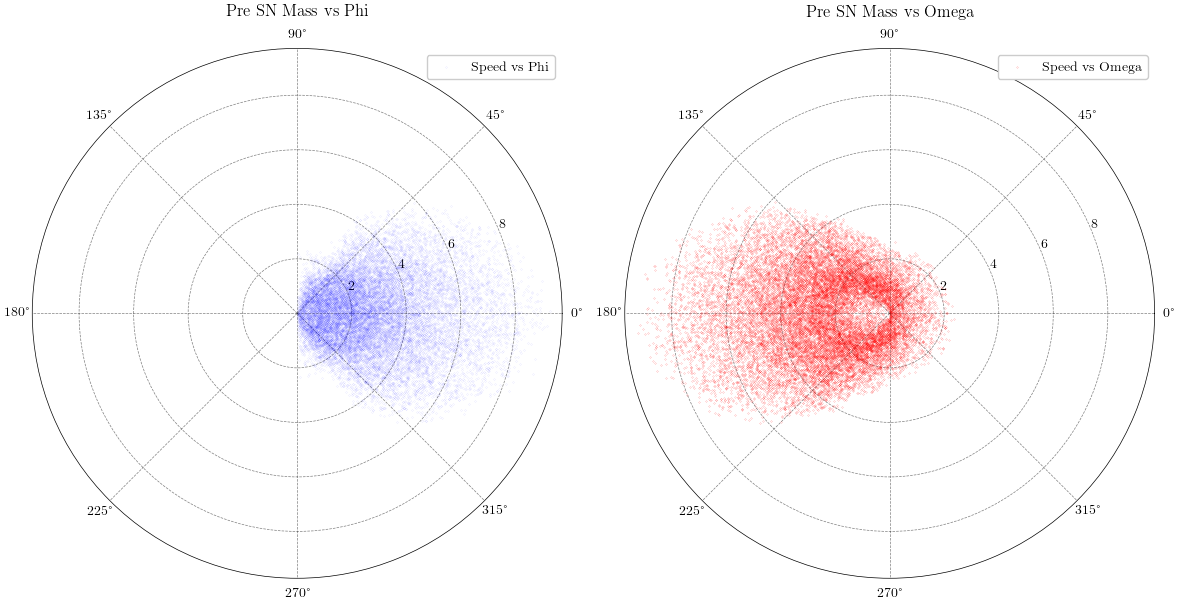

In [50]:
# Example data (replace with your actual data)
phi = table_subset[eject_cond]['phi']  # Angle phi (-pi/2 to pi/2)
omega = table_subset[eject_cond]['omega']         # Angle omega (0 to 2pi)
period_phi = table_subset[eject_cond]['period']          # Example speed vs phi
period_omega = table_subset[eject_cond]['period']       # Example speed vs omega

# Plot speed vs phi
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

# Speed vs Phi
axs[0].scatter(phi, period_phi, color='blue', label='Speed vs Phi', s = 0.001)
axs[0].set_title("Pre SN Mass vs Phi", va='bottom')

axs[0].legend()

# Speed vs Omega
axs[1].scatter(omega, period_omega, color='red', label='Speed vs Omega', s = 0.01)
axs[1].set_title("Pre SN Mass vs Omega", va='bottom')

axs[1].legend()

# Show plot
plt.tight_layout()
plt.show()

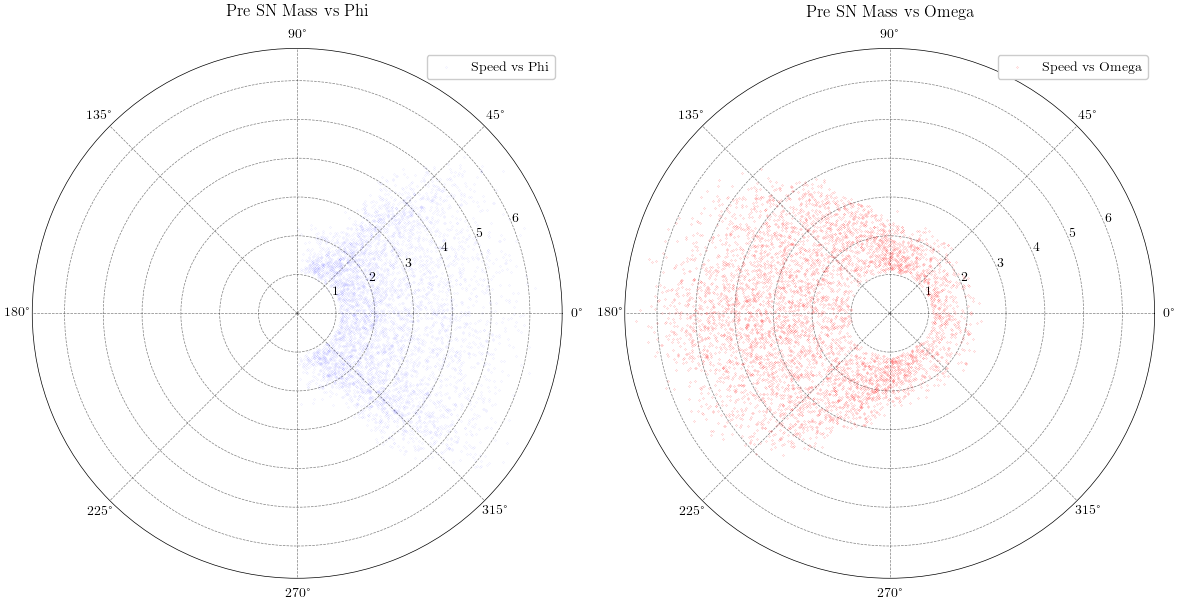

In [52]:
# Example data (replace with your actual data)
phi = table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['phi']  # Angle phi (-pi/2 to pi/2)
omega = table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['omega']         # Angle omega (0 to 2pi)
period_phi = table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['period']          # Example speed vs phi
period_omega = table_subset[eject_cond & pre_roche_lobe_cond & post_roche_lobe_cond]['period']       # Example speed vs omega

# Plot speed vs phi
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

# Speed vs Phi
axs[0].scatter(phi, period_phi, color='blue', label='Speed vs Phi', s = 0.001)
axs[0].set_title("Pre SN Mass vs Phi", va='bottom')

axs[0].legend()

# Speed vs Omega
axs[1].scatter(omega, period_omega, color='red', label='Speed vs Omega', s = 0.01)
axs[1].set_title("Pre SN Mass vs Omega", va='bottom')

axs[1].legend()

# Show plot
plt.tight_layout()
plt.show()

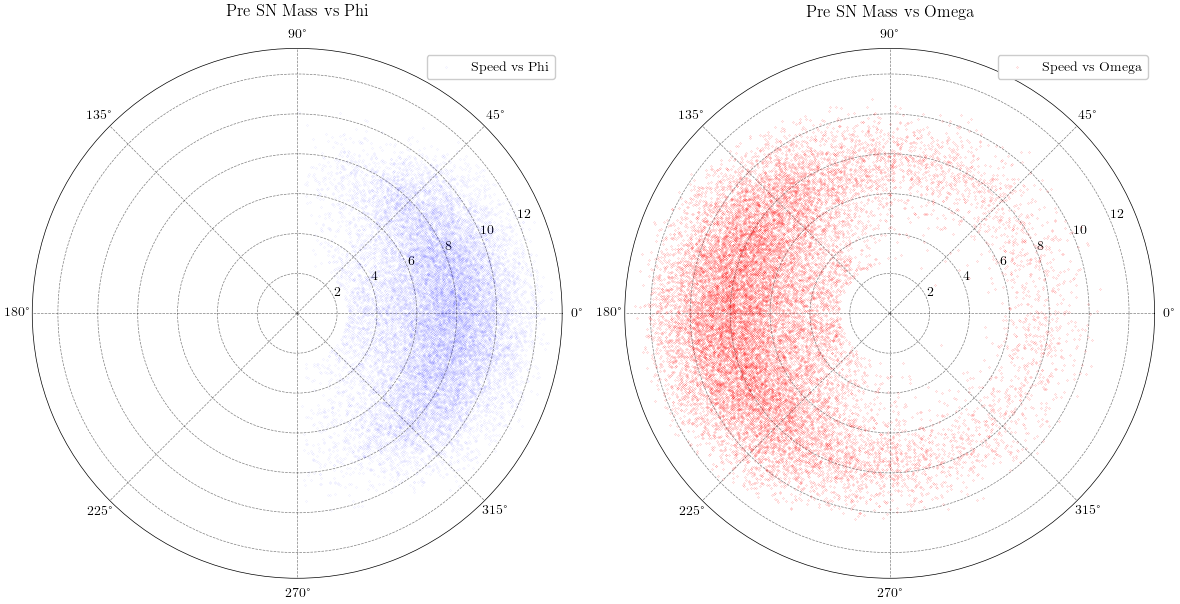

In [49]:
# Example data (replace with your actual data)
phi = table_subset[eject_cond]['phi']  # Angle phi (-pi/2 to pi/2)
omega = table_subset[eject_cond]['omega']         # Angle omega (0 to 2pi)
mass_phi = table_subset[eject_cond]['m1']          # Example speed vs phi
mass_omega = table_subset[eject_cond]['m1']       # Example speed vs omega

# Plot speed vs phi
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

# Speed vs Phi
axs[0].scatter(phi, mass_phi, color='blue', label='Speed vs Phi', s = 0.001)
axs[0].set_title("Pre SN Mass vs Phi", va='bottom')

axs[0].legend()

# Speed vs Omega
axs[1].scatter(omega, mass_omega, color='red', label='Speed vs Omega', s = 0.01)
axs[1].set_title("Pre SN Mass vs Omega", va='bottom')

axs[1].legend()

# Show plot
plt.tight_layout()
plt.show()

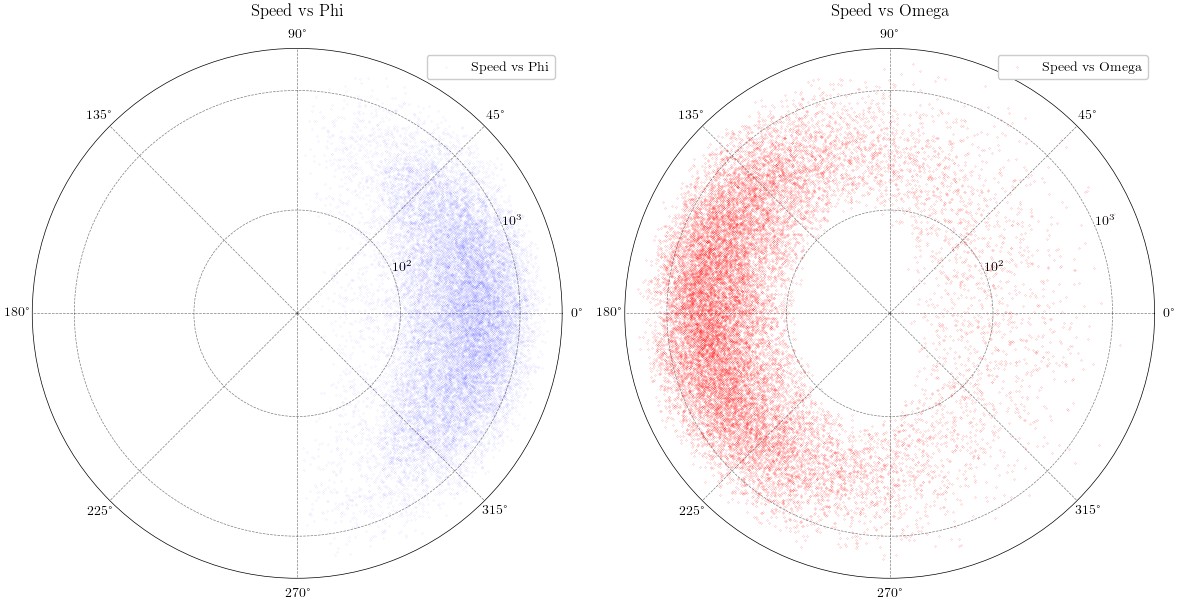

In [48]:
# Example data (replace with your actual data)
phi = table_subset[eject_cond]['phi']  # Angle phi (-pi/2 to pi/2)
omega = table_subset[eject_cond]['omega']         # Angle omega (0 to 2pi)
speed_phi = table_subset[eject_cond]['kick']          # Example speed vs phi
speed_omega = table_subset[eject_cond]['kick']       # Example speed vs omega

# Plot speed vs phi
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

# Speed vs Phi
axs[0].scatter(phi, speed_phi, color='blue', label='Speed vs Phi', s = 0.001)
axs[0].set_title("Speed vs Phi", va='bottom')
axs[0].set_yscale('log')
axs[0].legend()

# Speed vs Omega
axs[1].scatter(omega, speed_omega, color='red', label='Speed vs Omega', s = 0.01)
axs[1].set_title("Speed vs Omega", va='bottom')
axs[1].set_yscale('log')
axs[1].legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
plt.scatter(table_subset['kick'], table_subset['m1'], s = 0.1)
plt.scatter(table_subset[eject_cond]['kick'], table_subset[eject_cond]['m1'], s = 0.1)
plt.xlabel('kick (km/s)')
plt.ylabel('pre-SN progenitor mass (msun)')

In [ ]:
np.random.seed(1234)
N = int(1e7)
M2 = 58 * msun

vkick_min, vkick_max = 0 * kms, 1000 * kms
speed, angles = kick(vkick_min, vkick_max, N)
phi = angles[:,0]
omega = angles[:,1]

P_min, P_max = 0 * day, 20 * day
period = sample_orbital_period(P_min, P_max, N)

delta_m_min, delta_m_max = 0 * msun, 30 * msun
delta_m = sample_mass_loss(delta_m_min, delta_m_max, N)

initial_e = sample_eccentricities(N)
M = sample_mean_anomaly(N)
E = solve_kepler_equation(initial_e, M)

M1_prime = 2.5 * msun
M1 = calculate_progenitor_mass(delta_m, M1_prime)

a = pre_SN_a(M1, M2, period)

r = compute_radial_distance(a, initial_e, E)
sin_beta = compute_sin_beta(a, initial_e, r)
cos_beta = compute_cos_beta(initial_e, E)
vorb = compute_orbital_velocity(a, r, M1+M2)
vn_squared = post_SN_relative_velocity_squared(speed, vorb, omega, phi, sin_beta, cos_beta)
vn = np.sqrt(vn_squared)
final_a = semi_major_axis_from_v_r(vn, r , M1_prime+M2)
e = new_eccentricity(M1_prime+M2, final_a, r, speed, phi, omega, vorb, sin_beta)
vsys = compute_v_sys(vorb, sin_beta, cos_beta, speed, omega, phi, M1, M2, M1-M1_prime)
final_period = P_orb(M1_prime, M2, final_a)

In [ ]:
q = M2 / M1
rl_2 = a * (1 - initial_e) * f(q)

# Create the Astropy table with units preserved
table = Table(
    {
        "m1": M1,           # M1 with units (e.g., Msun)
        "a": a,             # Semi-major axis with units (e.g., AU)
        "period": period,   # Orbital period with units (e.g., day)
        "v_orb": vorb,      # Orbital velocity with units (e.g., km/s)
        "kick": speed,      # Kick speed with units (e.g., km/s)
        "omega": omega,     # Kick angle theta (radians)
        "phi": phi,         # Kick angle phi (radians)
        "e": e,             # Post-SN eccentricity (dimensionless)
        "v_sys": vsys,      # Systemic velocity with units (e.g., km/s)
        "final_a": final_a,
        "final_period": final_period,
        "d_peri": a * (1 - initial_e),
        "e_init": initial_e,
        "rl_2": rl_2
    }
)

e_cond = (table['e'] > 0.3) & (table['e'] < 1)
p_cond = (table['final_period'] < 4 * day)

table_subset = table[e_cond & p_cond]
eject_cond = (table_subset['v_sys'] > 50 * kms) & (table_subset['v_sys'] < 70 * kms)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.set_tight_layout(True)

# Histogram for Pre-SN semi-major axis
axs[0, 0].hist(table_subset['d_peri'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[0, 0].hist(table_subset[eject_cond]['d_peri'], bins='fd', density=True, color='red', histtype='step', label="eject")
#axs[0, 0].hist(table_subset[eject_cond]['rl_2'], bins='fd', density=True, color='green', histtype='step', label="eject")
axs[0,0].axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('Pre-SN d_peri (Rsun)')
axs[0, 0].set_ylabel('Density')
axs[0,0].set_xlim(0,100)
axs[0, 0].legend()

# Scatter plot for Pre-SN semi-major axis vs v_sys
axs[0, 1].scatter(table_subset['d_peri'], table_subset['v_sys'], s=1, color='black', label="All")
axs[0, 1].scatter(table_subset[eject_cond]['d_peri'], table_subset[eject_cond]['v_sys'], s=1, color='red', label="eject")
#axs[0, 1].hist(table_subset[eject_cond]['rl_2'], bins='fd', density=True, color='green', histtype='step', label="eject")
axs[0,1].axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)
axs[0, 1].set_xlabel('Pre-SN d_peri (Rsun)')
axs[0, 1].set_ylabel('v_sys (km/s)')
axs[0, 1].set_yscale('log')
axs[0, 1].legend()

# Histogram for m1
axs[1, 0].hist(table_subset['m1'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[1, 0].hist(table_subset[eject_cond]['m1'], bins='fd', density=True, color='red', histtype='step', label="eject")
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Pre-SN m1 (Msun)')
axs[1, 0].set_ylabel('Density')
axs[1,0].set_xlim(0,100)
axs[1, 0].legend()

# Histogram for kick
axs[1, 1].hist(table_subset['kick'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[1, 1].hist(table_subset[eject_cond]['kick'], bins='fd', density=True, color='red', histtype='step', label="eject")
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Kick speed (km/s)')
axs[1,1].set_xlim(-5,1000)
axs[1, 1].set_ylabel('Density')
axs[1, 1].legend()

# Histogram for v_sys
axs[2, 0].hist(table_subset['v_sys'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[2, 0].hist(table_subset[eject_cond]['v_sys'], bins='fd', density=True, color='red', histtype='step', label="eject")
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel('v_sys (km/s)')
axs[2,0].set_xlim(-5,1e3)
axs[2, 0].set_ylabel('Density')
axs[2, 0].legend()

# Histogram for v_sys
axs[2, 1].hist(table_subset['e_init'], bins='fd', density=True, color='black', histtype='step', label="All")
axs[2, 1].hist(table_subset[eject_cond]['e_init'], bins='fd', density=True, color='red', histtype='step', label="eject")
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel('e_init')
axs[2, 1].set_ylabel('Density')
axs[2, 1].legend()

# Display the plots
plt.show()

In [ ]:
plt.scatter(table_subset[eject_cond]['d_peri'], table_subset[eject_cond]['kick'], s = 0.01)
plt.axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)
plt.show()

plt.scatter(table_subset[eject_cond]['rl_2'], table_subset[eject_cond]['kick'], s = 0.01)
plt.axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)
plt.show()

In [ ]:
plt.scatter(table_subset[eject_cond]['d_peri'], table_subset[eject_cond]['m1'], s = 0.01)
plt.axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)
plt.show()

plt.scatter(table_subset[eject_cond]['rl_2'], table_subset[eject_cond]['m1'], s = 0.01)
plt.axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)
plt.show()

In [ ]:
plt.scatter(table_subset[eject_cond]['d_peri'], table_subset[eject_cond]['v_sys'], s = 0.01)
plt.axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)

In [ ]:
plt.scatter(table_subset[eject_cond]['d_peri'], table_subset[eject_cond]['e_init'], s = 0.01)
plt.axvspan(25.1-4, 25.1+4, color = 'magenta', alpha = 0.3)

In [ ]:
plt.scatter(table_subset[eject_cond]['e_init'], table_subset[eject_cond]['kick'], s = 0.01)

In [ ]:
df = table_subset.to_pandas()

In [ ]:
figure = corner.corner(df[['m1','d_peri','e_init','v_sys','kick']], axes_scale = ['linear', 'linear', 'linear', 'log', 'linear'], labels = ['m1','d_peri','e_init','v_sys','kick'])

In [ ]:
df_eject = table_subset[eject_cond].to_pandas()
figure = corner.corner(df[['m1','d_peri','e_init','kick']], axes_scale = ['linear', 'linear', 'linear', 'linear'], labels = ['m1','d_peri','e_init','kick'])